Group-level waveform analysis

https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

## Set up

In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

import mne
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
import mne_nirs

from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

import statsmodels.formula.api as smf
from scipy.stats import shapiro, levene, f_oneway, kruskal, ttest_ind, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import pickle

set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

## Individual analysis

In [29]:
# Constants for individual_analysis()

IA_CONST_DPF = {
    'P01': 5.82,
    'P02': 5.82,
    'P03': 5.73,
    'P04': 5.76,
    'P05': 5.76,
    'P06': 5.82,
    'P07': 5.76,
    'P08': 5.79,
    'P09': 5.76,
    'P10': 6.00,
    'P11': 5.91,
    'P12': 5.94,
    'P13': 5.88,
    'P14': 5.79,
    'P15': 6.20,
    'P16': 5.73,
    'P17': 5.94,
}
IA_CONST_RENAME_CHANNELS_MAPPING = {
    'S1_D1 hbr': 'S1_D1 760',
    'S1_D1 hbo': 'S1_D1 850',
    'S2_D1 hbr': 'S2_D1 760',
    'S2_D1 hbo': 'S2_D1 850',
    'S3_D1 hbr': 'S3_D1 760',
    'S3_D1 hbo': 'S3_D1 850',
    'S1_D2 hbr': 'S1_D2 760',
    'S1_D2 hbo': 'S1_D2 850',
    'S3_D2 hbr': 'S3_D2 760',
    'S3_D2 hbo': 'S3_D2 850',
    'S4_D2 hbr': 'S4_D2 760',
    'S4_D2 hbo': 'S4_D2 850',
    'S2_D3 hbr': 'S2_D3 760',
    'S2_D3 hbo': 'S2_D3 850',
    'S3_D3 hbr': 'S3_D3 760',
    'S3_D3 hbo': 'S3_D3 850',
    'S5_D3 hbr': 'S5_D3 760',
    'S5_D3 hbo': 'S5_D3 850',
    'S6_D3 hbr': 'S6_D3 760',
    'S6_D3 hbo': 'S6_D3 850',
    'S3_D4 hbr': 'S3_D4 760',
    'S3_D4 hbo': 'S3_D4 850',
    'S4_D4 hbr': 'S4_D4 760',
    'S4_D4 hbo': 'S4_D4 850',
    'S5_D4 hbr': 'S5_D4 760',
    'S5_D4 hbo': 'S5_D4 850',
    'S8_D4 hbr': 'S8_D4 760',
    'S8_D4 hbo': 'S8_D4 850',
    'S5_D5 hbr': 'S5_D5 760',
    'S5_D5 hbo': 'S5_D5 850',
    'S6_D5 hbr': 'S6_D5 760',
    'S6_D5 hbo': 'S6_D5 850',
    'S7_D5 hbr': 'S7_D5 760',
    'S7_D5 hbo': 'S7_D5 850',
    'S4_D6 hbr': 'S4_D6 760',
    'S4_D6 hbo': 'S4_D6 850',
    'S8_D6 hbr': 'S8_D6 760',
    'S8_D6 hbo': 'S8_D6 850',
    'S9_D6 hbr': 'S9_D6 760',
    'S9_D6 hbo': 'S9_D6 850',
    'S5_D7 hbr': 'S5_D7 760',
    'S5_D7 hbo': 'S5_D7 850',
    'S7_D7 hbr': 'S7_D7 760',
    'S7_D7 hbo': 'S7_D7 850',
    'S8_D7 hbr': 'S8_D7 760',
    'S8_D7 hbo': 'S8_D7 850',
    'S10_D7 hbr': 'S10_D7 760',
    'S10_D7 hbo': 'S10_D7 850',
    'S8_D8 hbr': 'S8_D8 760',
    'S8_D8 hbo': 'S8_D8 850',
    'S9_D8 hbr': 'S9_D8 760',
    'S9_D8 hbo': 'S9_D8 850',
    'S10_D8 hbr': 'S10_D8 760',
    'S10_D8 hbo': 'S10_D8 850',
}
IA_CONST_CH_NAMES = [
    'S1_D1 760',
    'S1_D1 850',
    'S2_D1 760',
    'S2_D1 850',
    'S3_D1 760',
    'S3_D1 850',
    'S1_D2 760',
    'S1_D2 850',
    'S3_D2 760',
    'S3_D2 850',
    'S4_D2 760',
    'S4_D2 850',
    'S2_D3 760',
    'S2_D3 850',
    'S3_D3 760',
    'S3_D3 850',
    'S5_D3 760',
    'S5_D3 850',
    'S6_D3 760',
    'S6_D3 850',
    'S3_D4 760',
    'S3_D4 850',
    'S4_D4 760',
    'S4_D4 850',
    'S5_D4 760',
    'S5_D4 850',
    'S8_D4 760',
    'S8_D4 850',
    'S5_D5 760',
    'S5_D5 850',
    'S6_D5 760',
    'S6_D5 850',
    'S7_D5 760',
    'S7_D5 850',
    'S4_D6 760',
    'S4_D6 850',
    'S8_D6 760',
    'S8_D6 850',
    'S9_D6 760',
    'S9_D6 850',
    'S5_D7 760',
    'S5_D7 850',
    'S7_D7 760',
    'S7_D7 850',
    'S8_D7 760',
    'S8_D7 850',
    'S10_D7 760',
    'S10_D7 850',
    'S8_D8 760',
    'S8_D8 850',
    'S9_D8 760',
    'S9_D8 850',
    'S10_D8 760',
    'S10_D8 850',
]
IA_CONST_CH_TYPES = [
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
]
IA_CONST_EPOCH_DURATION = 15




In [30]:
def individual_analysis(participant_id):
    """
    Runs the preprocessing and epoching for a given participant.

    Steps:
    1. Load raw data
    2. Load self-report data
    3. Annotate raw data with event markers
    4. Rename channels and set channel types
    5. Compute scalp coupling index and mark bad channels
    6. Peak power rejection
    7. TDDR artifact correction
    8. Beer–Lambert Law to convert to haemoglobin
    9. Filter and negative correlation enhancement
    10. Create epochs based on self-reports
    """
    participant_id = participant_id
    supplementary_data = {}
    supplementary_data['participant_id'] = participant_id

    # ------------------------------
    #           Load data
    # ------------------------------

    fname = f'data/mne_raw/{participant_id}.fif'
    raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
    self_reports_csv = pd.read_csv(f'data/self-reports/{participant_id}.csv', header=None)
    self_reports = self_reports_csv.values

    duration = len(raw) / raw.info['sfreq']



    # ------------------------------
    #           Annotations
    # ------------------------------

    original_annotations = raw.annotations.copy()

    # Workaround because some data files have 1 non-prompt annotation while some have 2
    number_of_baseline_annotations = 0
    for i in range(len(original_annotations)):
        if 'baseline starts' in original_annotations[i].values():
            number_of_baseline_annotations += 1
        elif 'baseline ends/cycling starts' in original_annotations[i].values():
            number_of_baseline_annotations += 1
        if number_of_baseline_annotations == 2:
            break
    if number_of_baseline_annotations == 1:
        onset = original_annotations[1:].onset.copy() - 180 # onset
        duration = np.array([180] * len(original_annotations[1:]))
        description = self_reports[0].copy()
        description = np.char.add('sr', description.astype(str))
    elif number_of_baseline_annotations == 2:
        onset = original_annotations[2:].onset.copy() - 180 # onset
        duration = np.array([180] * len(original_annotations[2:]))
        description = self_reports[0].copy()
        description = np.char.add('sr', description.astype(str))

    # Add baseline
    if raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0] > 90:
        onset = np.insert(onset, 0, 
                    raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0] - 90)
        duration = np.insert(duration, 0, 90)
    else:
        onset = np.insert(onset, 0, 0)
        duration = np.insert(duration, 0, 
                            raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0])

    # Workaround for 'baseline' getting truncated to 'bas'
    description = description.astype('object')
    description = np.insert(description, 0, 'baseline')

    # Set annotations to raw
    raw.set_annotations(
        annotations = mne.Annotations(onset=onset, duration=duration, description=description)

    )

    
    # ---------------------------------------
    #           Patch channel types
    # ---------------------------------------

    raw.rename_channels(IA_CONST_RENAME_CHANNELS_MAPPING)
    raw.set_channel_types(dict(zip(IA_CONST_CH_NAMES, IA_CONST_CH_TYPES)))

    # Workaround for setting wavelengths
    for i in range(len(raw.info['chs'])):
        if raw.info['chs'][i]['ch_name'].endswith('760'):
            raw.info['chs'][i]['loc'][9] = 7.60000000e+02
        elif raw.info['chs'][i]['ch_name'].endswith('850'):
            raw.info['chs'][i]['loc'][9] = 8.50000000e+02
    

    # ------------------------------------
    #           Signal quality
    # ------------------------------------

    # scalp coupling index
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw)
    raw.info['bads'] = list(compress(raw.ch_names, sci < 0.7))
    supplementary_data['sci'] = sci

    # peak power
    raw, scores, times = mne_nirs.preprocessing.peak_power(raw, time_window=10)

    # Temporal derivative distribution repair
    raw = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw)

    supplementary_data['number_of_bad_channels'] = len(raw.info['bads'])


    # -------------------------------------
    #           Haemo conversion
    # -------------------------------------

    # raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=DPF[participant_id])
    # raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=0.1)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=IA_CONST_DPF[participant_id]/50)

    # removing heart rate from signal
    raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

    # negative correlation enhancement algorithm
    raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)


    # -------------------------------
    #           Epoching
    # -------------------------------

    # crop data
    raw_haemo.crop(
        tmin = raw_haemo.annotations[raw_haemo.annotations.description == 'baseline'].onset[0] 
        + raw_haemo.annotations[raw_haemo.annotations.description == 'baseline'].duration[0] 
        - IA_CONST_EPOCH_DURATION,
    )

    # exclude baseline
    events, event_id = mne.events_from_annotations(raw_haemo, chunk_duration=IA_CONST_EPOCH_DURATION, verbose=True)
    del event_id['baseline']

    # create epochs
    reject_criteria = dict(hbo=80e-6, hbr=80e-6)
    tmin, tmax = 0, IA_CONST_EPOCH_DURATION
    baseline = (0, IA_CONST_EPOCH_DURATION)
    epochs = mne.Epochs(raw_haemo, events, event_id=event_id, 
                        tmin=tmin, tmax=tmax, baseline=baseline, preload=True, 
                        reject=None, reject_by_annotation=True)

    
    return raw_haemo, epochs, supplementary_data


## Run analysis on all data

In [31]:
# run analysis on all data
# PARTICIPANTS = ['P05', 'P06', 'P07']

PARTICIPANTS = ['P01', 'P02', 'P03', 'P04', 'P05',
                'P06', 'P07', 'P08', 'P09', 'P10',
                'P11', 'P12', 'P13', 'P14', 'P15',
                'P16', 'P17']

all_evokeds = defaultdict(list)

all_supplementary_data = []

for participant in PARTICIPANTS:  # Loop from first to fifth subject
    # Analyse data and return both ROI and channel results
    raw_haemo, epochs, supplementary_data = individual_analysis(participant)
    all_supplementary_data.append(supplementary_data)

    # Save individual-evoked participant data along with others in all_evokeds
    for cidx, condition in enumerate(epochs.event_id):
        all_evokeds[condition].append(epochs[condition].average())

# save to file
# with open('Dumped/raw_haemo', 'wb') as f:
#     pickle.dump(raw_haemo, f)
# with open('Dumped/epochs', 'wb') as f:
#     pickle.dump(epochs, f)
# with open('Dumped/all_evokeds', 'wb') as f:
#     pickle.dump(all_evokeds, f)
# with open('Dumped/all_supplementary_data', 'wb') as f:
#     pickle.dump(all_supplementary_data, f)

Opening raw data file data/mne_raw/P01.fif...
    Range : 0 ... 96657 =      0.000 ...  1933.140 secs
Ready.
Reading 0 ... 96657  =      0.000 ...  1933.140 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P02.fif...
    Range : 0 ... 97045 =      0.000 ...  1940.900 secs
Ready.
Reading 0 ... 97045  =      0.000 ...  1940.900 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P03.fif...
    Range : 0 ... 94803 =      0.000 ...  1896.060 secs
Ready.
Reading 0 ... 94803  =      0.000 ...  1896.060 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P04.fif...
    Range : 0 ... 91744 =      0.000 ...  1834.880 secs
Ready.
Reading 0 ... 91744  =      0.000 ...  1834.880 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P05.fif...
    Range : 0 ... 88463 =      0.000 ...  1769.260 secs
Ready.
Reading 0 ... 88463  =      0.000 ...  1769.260 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P06.fif...
    Range : 0 ... 90396 =      0.000 ...  1807.920 secs
Ready.
Reading 0 ... 90396  =      0.000 ...  1807.920 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P06.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P07.fif...
    Range : 0 ... 116746 =      0.000 ...  2334.920 secs
Ready.
Reading 0 ... 116746  =      0.000 ...  2334.920 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P08.fif...
    Range : 0 ... 92833 =      0.000 ...  1856.660 secs
Ready.
Reading 0 ... 92833  =      0.000 ...  1856.660 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P08.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr3')]
Opening raw data file data/mne_raw/P09.fif...
    Range : 0 ... 152426 =      0.000 ...  3048.520 secs
Ready.
Reading 0 ... 152426  =      0.000 ...  3048.520 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P10.fif...
    Range : 0 ... 94406 =      0.000 ...  1888.120 secs
Ready.
Reading 0 ... 94406  =      0.000 ...  1888.120 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P11.fif...
    Range : 0 ... 93080 =      0.000 ...  1861.600 secs
Ready.
Reading 0 ... 93080  =      0.000 ...  1861.600 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P12.fif...
    Range : 0 ... 88999 =      0.000 ...  1779.980 secs
Ready.
Reading 0 ... 88999  =      0.000 ...  1779.980 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P13.fif...
    Range : 0 ... 92295 =      0.000 ...  1845.900 secs
Ready.
Reading 0 ... 92295  =      0.000 ...  1845.900 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P14.fif...
    Range : 0 ... 82882 =      0.000 ...  1657.640 secs
Ready.
Reading 0 ... 82882  =      0.000 ...  1657.640 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P15.fif...
    Range : 0 ... 90435 =      0.000 ...  1808.700 secs
Ready.
Reading 0 ... 90435  =      0.000 ...  1808.700 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P16.fif...
    Range : 0 ... 115869 =      0.000 ...  2317.380 secs
Ready.
Reading 0 ... 115869  =      0.000 ...  2317.380 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Opening raw data file data/mne_raw/P17.fif...
    Range : 0 ... 144304 =      0.000 ...  2886.080 secs
Ready.
Reading 0 ... 144304  =      0.000 ...  2886.080 secs...


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:26: RuntimeWarning: This filename (data/mne_raw/P17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/1493547312.py:86: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_

Used Annotations descriptions: [np.str_('baseline'), np.str_('sr1'), np.str_('sr2'), np.str_('sr3')]


In [32]:
# optionally load file

# with open('Dumped/raw_haemo', 'rb') as f:
#     raw_haemo = pickle.load(f)
# with open('Dumped/epochs', 'rb') as f:
#     epochs = pickle.load(f)
# with open('Dumped/all_evokeds', 'rb') as f:
#     all_evokeds = pickle.load(f)


## View average waveform

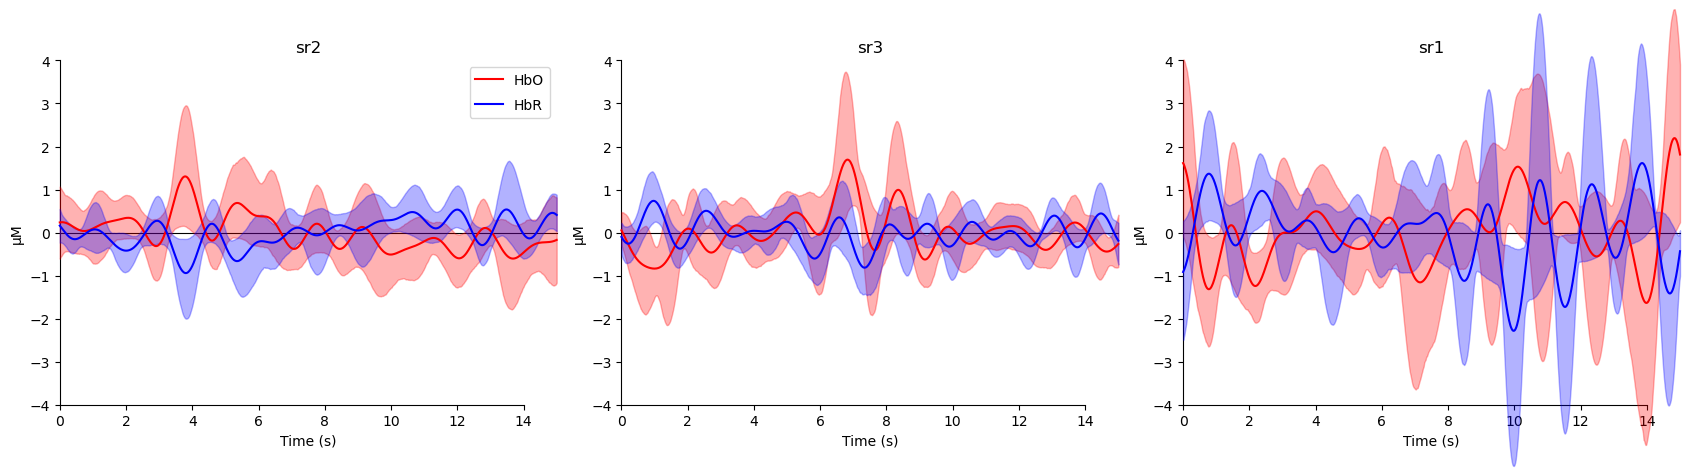

In [33]:
plt.rcParams['legend.labelspacing'] = -0.1

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-4, 4], hbr=[-4, 4])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        # print(idx)
        # print(evoked)
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == None)
        axes[idx].set_title('{}'.format(evoked))
legend = axes[0].legend(['HbO', None, 'HbR'])
legend.legend_handles[1].set_visible(False) # hide the second label
fig.tight_layout()



## Compare means for sr1, sr2, sr3

In [34]:

sr1_all_means = []
sr2_all_means = []
sr3_all_means = []

for i in range(len(all_evokeds['sr1'])):
    sr1_all_means.append(np.mean(all_evokeds['sr1'][i].get_data()))
for i in range(len(all_evokeds['sr2'])):
    sr2_all_means.append(np.mean(all_evokeds['sr2'][i].get_data()))
for i in range(len(all_evokeds['sr3'])):
    sr3_all_means.append(np.mean(all_evokeds['sr3'][i].get_data()))

sr1_all_means = np.asarray(sr1_all_means)
sr2_all_means = np.asarray(sr2_all_means)
sr3_all_means = np.asarray(sr3_all_means)

sr1, mean=1.0042250851700637e-23, std=2.003052729646966e-23
sr2, mean=-1.0782678873108265e-23, std=3.133206581785898e-23
sr3, mean=1.681674030202755e-24, std=3.5873119593763123e-23


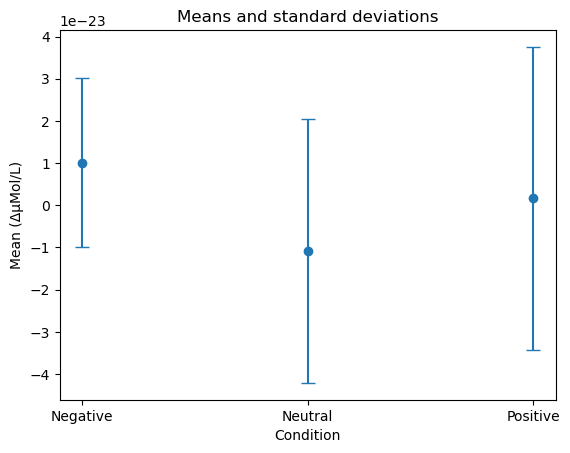

In [35]:
print(f'sr1, mean={sr1_all_means.mean()}, std={sr1_all_means.std()}')
print(f'sr2, mean={sr2_all_means.mean()}, std={sr2_all_means.std()}')
print(f'sr3, mean={sr3_all_means.mean()}, std={sr3_all_means.std()}')

means = [sr1_all_means.mean(), sr2_all_means.mean(), sr3_all_means.mean()]
stds = [sr1_all_means.std(), sr2_all_means.std(), sr3_all_means.std()]
labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots()
ax.errorbar(labels, means, yerr=stds, fmt='o', capsize=5)

plt.xlabel('Condition')
plt.ylabel('Mean (ΔμMol/L)')
plt.title('Means and standard deviations')
plt.show()

## Generate regions of interest

In [36]:
# Specify channel pairs for each ROI

all = [[9, 6], [4, 6], [9, 8], [8, 6], [8, 8], [8, 4], [10, 8], [8, 7], [10, 7], [5, 7], [7, 7], [7, 5],
       [4, 2], [1, 2], [3, 2], [1, 1], [3, 4], [3, 1], [
    3, 3], [2, 1], [5, 3], [2, 3], [6, 3], [6, 5],
    [4, 4], [5, 4], [5, 5]]
left = [[9, 6], [4, 6], [9, 8], [8, 6], [8, 8], [8, 4],
        [10, 8], [8, 7], [10, 7], [5, 7], [7, 7], [7, 5]]
right = [[4, 2], [1, 2], [3, 2], [1, 1], [3, 4], [3, 1],
         [3, 3], [2, 1], [5, 3], [2, 3], [6, 3], [6, 5]]

frontopolar_pfc = [[9, 6], [4, 6], [4, 2], [1, 2],
                   [9, 8], [8, 6], [4, 4], [3, 2], [1, 1],
                   [8, 8], [8, 4], [3, 4], [3, 1]]
dorsolateral_pfc = [[8, 8], [8, 4], [3, 4], [3, 1],
                    [10, 8], [8, 7], [5, 4], [3, 3], [2, 1],
                    [10, 7], [5, 7], [5, 3], [2, 3]]
frontal_cortex = [[5, 7], [5, 3],
                  [7, 7], [5, 5], [6, 3],
                  [7, 5], [6, 5]]

## Create average waveform per ROI

### Left/right hemisphere

In [37]:
rois = dict(Left=picks_pair_to_idx(raw_haemo, left),
            Right=picks_pair_to_idx(raw_haemo, right))


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/2018595267.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


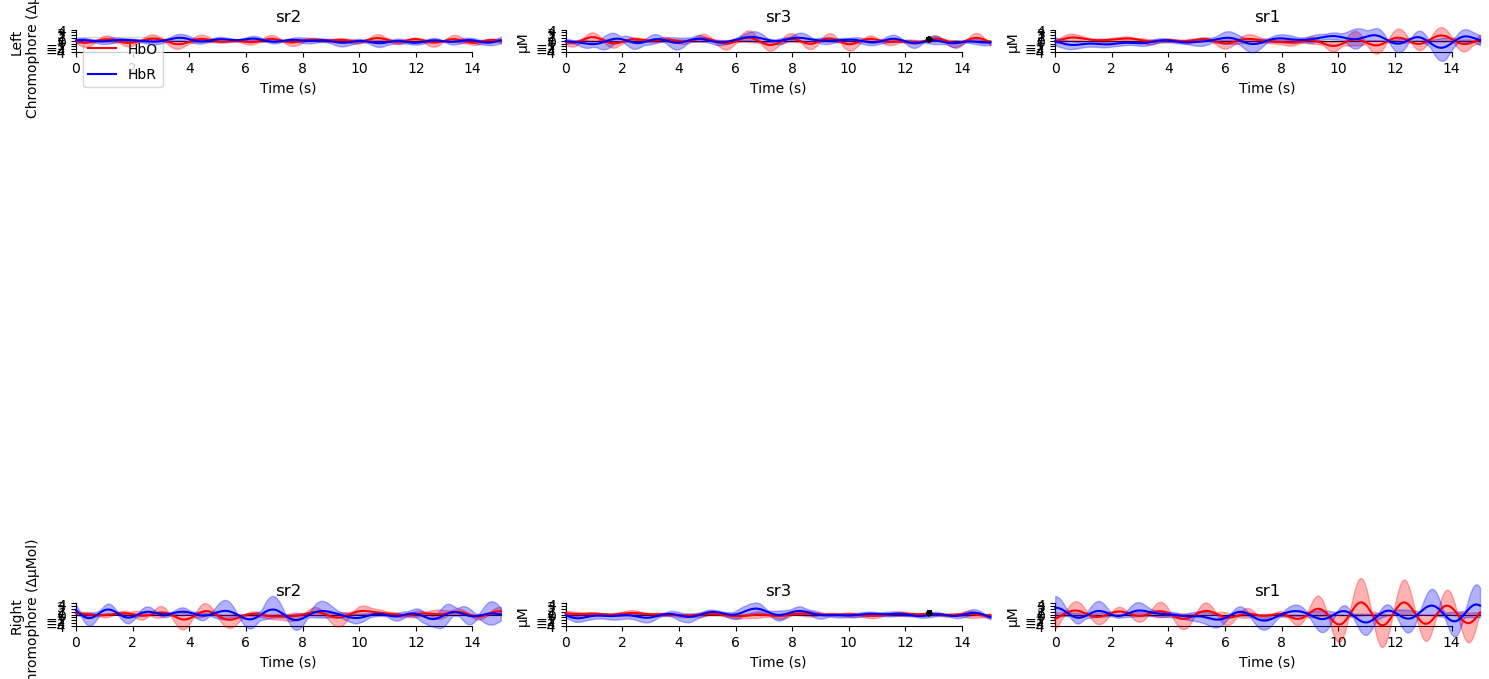

In [38]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds),
                         figsize=(15, 10))
lims = dict(hbo=[-4, 4], hbr=[-4, 4])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][0::2]  # 0-based are the 760 nm (HbR)
            else:
                picks = rois[roi][1::2]  # 1-based are the 850 nm (HbO)
            plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                 picks=picks, axes=axes[ridx, cidx],
                                 show=False, colors=[color], legend=False,
                                 ylim=lims, ci=0.95, show_sensors=cidx == 1)
            # axes[ridx, cidx].set_title("") # no clue what this line was for
            axes[ridx, cidx].set_title(f"{evoked}")
        # axes[0, cidx].set_title(f"{evoked}") # no clue what this line was for
        axes[ridx, 0].set_ylabel(f"{roi.replace('_', ' ')}\nChromophore (ΔμMol)")
legend = axes[0, 0].legend(['HbO', None, 'HbR'])
legend.legend_handles[1].set_visible(False) # hide the second label

fig.tight_layout()


## Regions

In [39]:
# Then generate the correct indices for each pair and store in dictionary
rois = dict(Frontopolar_PFC=picks_pair_to_idx(raw_haemo, frontopolar_pfc),
            Dorsolateral_PFC=picks_pair_to_idx(raw_haemo, dorsolateral_pfc),
            Frontal_cortex=picks_pair_to_idx(raw_haemo, frontal_cortex),)

# pprint(rois)

/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/2088467806.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_3266/2088467806.py:25: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


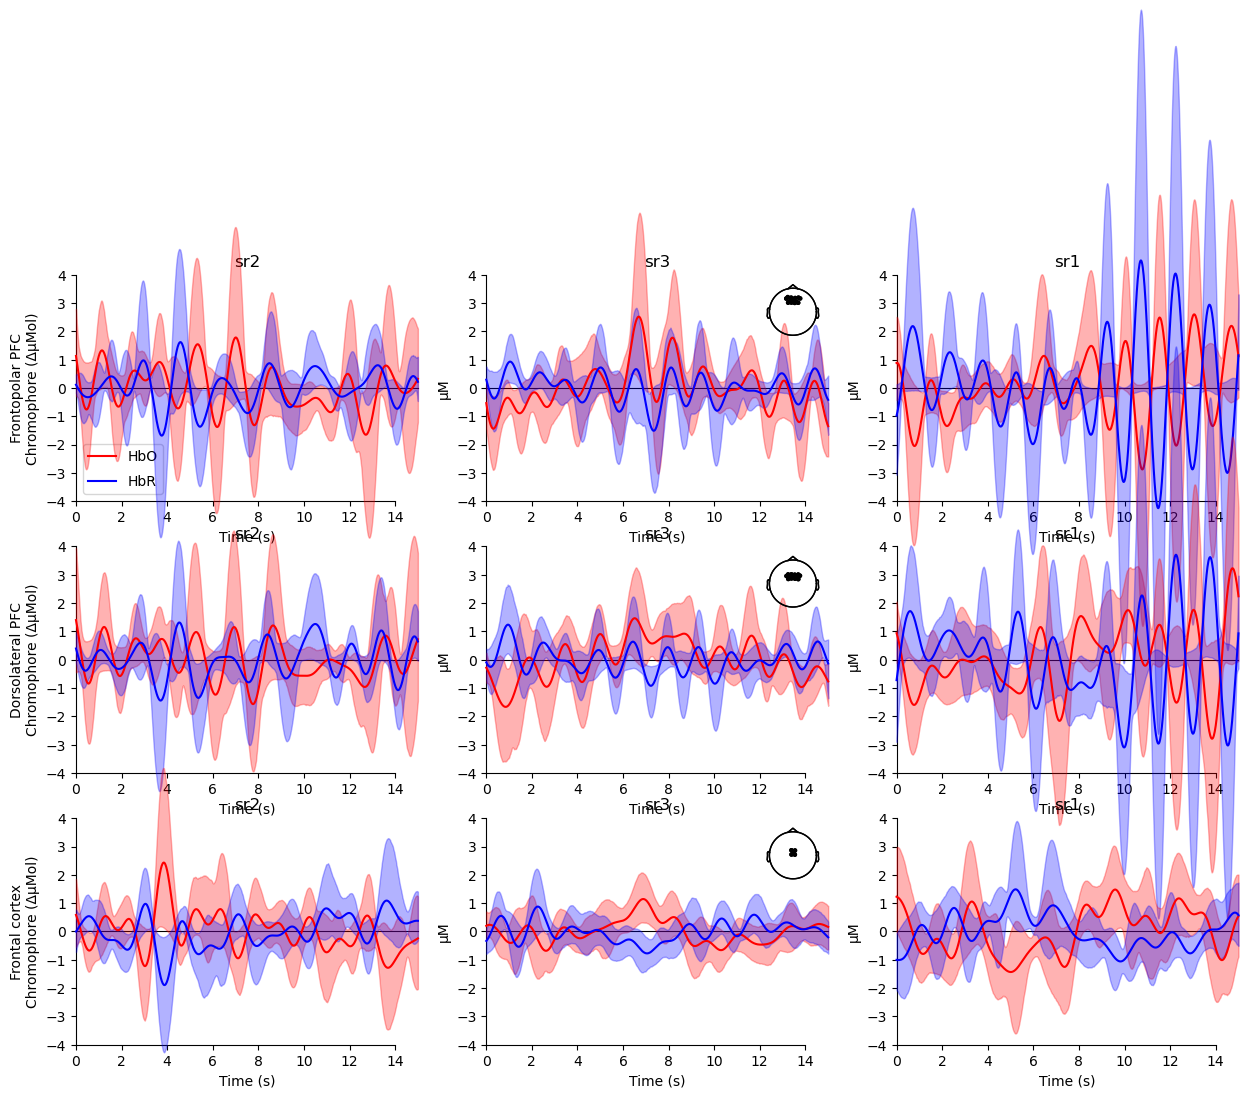

In [40]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds),
                         figsize=(15, 10))
lims = dict(hbo=[-4, 4], hbr=[-4, 4])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                 picks=picks, axes=axes[ridx, cidx],
                                 show=False, colors=[color], legend=False,
                                 ylim=lims, ci=0.95, show_sensors=cidx == 1)
            # axes[ridx, cidx].set_title("") # no clue what this line was for
            axes[ridx, cidx].set_title(f"{evoked}")
        # axes[0, cidx].set_title(f"{evoked}") # no clue what this line was for
        axes[ridx, 0].set_ylabel(f"{roi.replace('_', ' ')}\nChromophore (ΔμMol)")
legend = axes[0, 0].legend(['HbO', None, 'HbR'])
legend.legend_handles[1].set_visible(False) # hide the second label

fig.tight_layout()


## Mixed-effects model

In [41]:
df_list = []


for cond in all_evokeds.keys():
    for i, evoked_obj in enumerate(all_evokeds[cond]):
        participant_id = i + 1

        evoked_hbo = evoked_obj.copy().pick("hbo") 

        data_array = evoked_hbo.data

        mean_across_channels = data_array.mean(axis=0)

        time_array = evoked_hbo.times

        for t_idx, time_val in enumerate(time_array):
            df_list.append({
                "Participant": participant_id,
                "Condition": cond,
                "TimePoint": time_val,
                "AvgHbO": mean_across_channels[t_idx] * 1e6
            })

df_long = pd.DataFrame(df_list)

df_long["Condition"] = pd.Categorical(
    df_long["Condition"],
    categories=["sr2", "sr1", "sr3"],  # sr2 first -> reference
    ordered=False
)


In [42]:
df_long

,Participant,Condition,TimePoint,AvgHbO
0,1,sr2,0.00,7.075536
1,1,sr2,0.02,6.548499
2,1,sr2,0.04,5.974610
3,1,sr2,0.06,5.359135
4,1,sr2,0.08,4.707415
...,...,...,...,...
32288,10,sr1,14.92,1.371166
32289,10,sr1,14.94,1.327268
32290,10,sr1,14.96,1.288411
32291,10,sr1,14.98,1.254889


In [43]:

model = smf.mixedlm("AvgHbO ~ Condition",
                    data=df_long,
                    groups=df_long["Participant"])
results = model.fit()
print(results.summary())



/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: AvgHbO     
No. Observations:   32293   Method:             REML       
No. Groups:         17      Scale:              4.2008     
Min. group size:    751     Log-Likelihood:     -69004.0823
Max. group size:    2253    Converged:          Yes        
Mean group size:    1899.6                                 
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.000    0.019 -0.000 1.000 -0.037  0.037
Condition[T.sr1]  0.000    0.030  0.000 1.000 -0.059  0.059
Condition[T.sr3]  0.000    0.026  0.000 1.000 -0.051  0.051
Group Var         0.000                                    



/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [44]:

rois = dict(Left=picks_pair_to_idx(raw_haemo, left),
            Right=picks_pair_to_idx(raw_haemo, right))

df_list_roi = []

for cond in ["sr1", "sr2", "sr3"]:
    for subj_idx, evoked_obj in enumerate(all_evokeds[cond]):
        participant_id = subj_idx + 1
        time_array = evoked_obj.times
        for hemi in ['Left', 'Right']:
            roi_indices = rois[hemi]
            roi_hbo_indices = roi_indices[1::2]
            roi_ch_names = [evoked_obj.ch_names[idx] for idx in roi_hbo_indices if idx < len(evoked_obj.ch_names)]
            if len(roi_ch_names) == 0:
                continue
            evoked_roi = evoked_obj.copy().pick_channels(roi_ch_names)
            mean_roi = evoked_roi.data.mean(axis=0)
            for t_idx, time_val in enumerate(time_array):
                df_list_roi.append({
                    "Participant": participant_id,
                    "Condition": cond,
                    "TimePoint": time_val,
                    "Hemisphere": hemi,
                    "AvgHbO": mean_roi[t_idx] * 1e6 
                })

df_roi = pd.DataFrame(df_list_roi)

df_roi_h2 = df_roi[df_roi["Condition"].isin(["sr1", "sr2", "sr3"])].copy()

df_roi_h2["Condition"] = pd.Categorical(df_roi_h2["Condition"], categories=["sr2", "sr1", "sr3"], ordered=False)


# Left hemisphere:  H2
print("H2")
df_left = df_roi_h2[df_roi_h2["Hemisphere"] == "Left"]
model_left = smf.mixedlm("AvgHbO ~ Condition", data=df_left, groups=df_left["Participant"])
results_left = model_left.fit()
print(results_left.summary())


# Right hemisphere: H3
print("H3")
df_right = df_roi_h2[df_roi_h2["Hemisphere"] == "Right"]
model_right = smf.mixedlm("AvgHbO ~ Condition", data=df_right, groups=df_right["Participant"])
results_right = model_right.fit()
print(results_right.summary())



H2


/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packa

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: AvgHbO     
No. Observations:   32293   Method:             REML       
No. Groups:         17      Scale:              4.3069     
Min. group size:    751     Log-Likelihood:     -69406.7021
Max. group size:    2253    Converged:          No         
Mean group size:    1899.6                                 
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.000    0.019 -0.000 1.000 -0.037  0.037
Condition[T.sr1]  0.000    0.031  0.000 1.000 -0.060  0.060
Condition[T.sr3]  0.000    0.026  0.000 1.000 -0.052  0.052
Group Var         0.000                                    

H3
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: AvgHbO     
No. Observations:   32293   Method:             REML      

/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:


# Global Means (H1)
print("Assumption checks (Global means)")
print("\nNormality tests (Shapiro-Wilk):")
w, p = shapiro(sr1_all_means)
print("Negative (sr1): W = {:.3f}, p = {:.3f}".format(w, p))
w, p = shapiro(sr2_all_means)
print("Neutral (sr2): W = {:.3f}, p = {:.3f}".format(w, p))
w, p = shapiro(sr3_all_means)
print("Positive (sr3): W = {:.3f}, p = {:.3f}".format(w, p))

print("\nHomogeneity of Variance (Levene's Test):")
stat, p = levene(sr1_all_means, sr2_all_means, sr3_all_means)
print("Levene's Test: stat = {:.3f}, p = {:.3f}".format(stat, p))

# ANOVA
F, p = f_oneway(sr1_all_means, sr2_all_means, sr3_all_means)
print("\nANOVA Test:")
print("F = {:.3f}, p = {:.3f}".format(F, p))

# Kruskal-Wallis
H, p = kruskal(sr1_all_means, sr2_all_means, sr3_all_means)
print("\nKruskal-Wallis Test:")
print("H = {:.3f}, p = {:.3f}".format(H, p))

# Pairwise t-tests
print("\nPairwise t-tests:")
t, p = ttest_ind(sr1_all_means, sr2_all_means, equal_var=True)
print("Negative (sr1) vs Neutral (sr2): t = {:.3f}, p = {:.3f}".format(t, p))
t, p = ttest_ind(sr1_all_means, sr3_all_means, equal_var=True)
print("Negative (sr1) vs Positive (sr3): t = {:.3f}, p = {:.3f}".format(t, p))
t, p = ttest_ind(sr2_all_means, sr3_all_means, equal_var=True)
print("Neutral (sr2) vs Positive (sr3): t = {:.3f}, p = {:.3f}".format(t, p))

# Tukey's HSD
print("\nTukey's HSD Test:")
all_means = np.concatenate([sr1_all_means, sr2_all_means, sr3_all_means])
group_labels = (['Negative'] * len(sr1_all_means)) + (['Neutral'] * len(sr2_all_means)) + (['Positive'] * len(sr3_all_means))
tukey = pairwise_tukeyhsd(endog=all_means, groups=group_labels, alpha=0.05)
print(tukey)

# Mann-Whitney U Tests
print("\nMann-Whitney U Tests:")
u, p = mannwhitneyu(sr1_all_means, sr2_all_means, alternative='two-sided')
print("Negative (sr1) vs Neutral (sr2): U = {:.3f}, p = {:.3f}".format(u, p))
u, p = mannwhitneyu(sr1_all_means, sr3_all_means, alternative='two-sided')
print("Negative (sr1) vs Positive (sr3): U = {:.3f}, p = {:.3f}".format(u, p))
u, p = mannwhitneyu(sr2_all_means, sr3_all_means, alternative='two-sided')
print("Neutral (sr2) vs Positive (sr3): U = {:.3f}, p = {:.3f}".format(u, p))


# ROI analyses for H2 and H3

# Left Hemisphere
df_left_roi = df_roi[df_roi["Hemisphere"] == "Left"]
# Filter only negative and positive conditions (sr1 and sr3)
df_left_roi = df_left_roi[df_left_roi["Condition"].isin(["sr1", "sr3"])]
# Aggregate across timepoints per participant per condition
df_left_agg = df_left_roi.groupby(["Participant", "Condition"])["AvgHbO"].mean().reset_index()
df_left_pivot = df_left_agg.pivot(index="Participant", columns="Condition", values="AvgHbO").dropna()
print("\n=== Left Hemisphere ROI Means (H2) ===")
print(df_left_pivot)
t, p = ttest_ind(df_left_pivot['sr1'], df_left_pivot['sr3'], equal_var=True)
print("Left Hemisphere t-test (Negative vs Positive): t = {:.3f}, p = {:.3f}".format(t, p))

# Right Hemisphere
df_right_roi = df_roi[df_roi["Hemisphere"] == "Right"]
df_right_roi = df_right_roi[df_right_roi["Condition"].isin(["sr1", "sr3"])]
df_right_agg = df_right_roi.groupby(["Participant", "Condition"])["AvgHbO"].mean().reset_index()
df_right_pivot = df_right_agg.pivot(index="Participant", columns="Condition", values="AvgHbO").dropna()
print("\n=== Right Hemisphere ROI Means (H3) ===")
print(df_right_pivot)
t, p = ttest_ind(df_right_pivot['sr1'], df_right_pivot['sr3'], equal_var=True)
print("Right Hemisphere t-test (Negative vs Positive): t = {:.3f}, p = {:.3f}".format(t, p))


/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


=== Assumption Checks (Global Means) ===

Normality Tests (Shapiro-Wilk):
Negative (sr1): W = 1.000, p = 1.000
Neutral (sr2): W = 1.000, p = 1.000
Positive (sr3): W = 1.000, p = 1.000

Homogeneity of Variance (Levene's Test):
Levene's Test: stat = 0.273, p = 0.762

ANOVA Test:
F = 1.381, p = 0.263

Kruskal-Wallis Test:
H = 5.136, p = 0.077

Pairwise t-tests:
Negative (sr1) vs Neutral (sr2): t = 1.802, p = 0.084
Negative (sr1) vs Positive (sr3): t = 0.652, p = 0.520
Neutral (sr2) vs Positive (sr3): t = -1.028, p = 0.312

Tukey's HSD Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1   group2  meandiff p-adj  lower upper reject
----------------------------------------------------
Negative  Neutral     -0.0 0.2566  -0.0   0.0  False
Negative Positive     -0.0 0.7931  -0.0   0.0  False
 Neutral Positive      0.0 0.5138  -0.0   0.0  False
----------------------------------------------------

Mann-Whitney U Tests:
Negative (sr1) vs Neutral (sr2): U = 106.000, p = 0.179
Negati